* **Use the module [`g.extension`]() to install the following `GRASS GIS ADDONS`:**
    * [`r.geomorphon`](https://grass.osgeo.org/grass72/manuals/addons/r.geomorphon.html)
    * [`r.area`](https://grass.osgeo.org/grass72/manuals/addons/r.area.html)
    * [`v.transects`](https://grass.osgeo.org/grass72/manuals/addons/v.transects.html)

In [1]:
%%file gutil.ipy
import base64
from IPython.display import HTML, display
def makefigure(layers, label=''):
    html = "<table><tr>"
    for i in layers:
        outname=i+'.png'
        rasterlist = !g.list raster
        if i in rasterlist:
            !r.out.png -t -w input={i} output={i}.png --o --qq
        else:
            !v.out.png input={i} output={i}.png --o --qq
        imageFile = open(outname, "rb")
        imagebyte = base64.b64encode(imageFile.read())
        imagestr = imagebyte.decode()
        html+="""<td><p><img src="data:image/png;base64,%s" alt="" width='600'/></p></td>""" % imagestr
    html += "</tr></table><p><center>%s</center></p>" % label 
    display(HTML(html))

Writing gutil.ipy


In [2]:
%run gutil.ipy

* **Get the bathymetry data**

In [3]:
!wget -O bathy_2015.tif https://nextcloud.epinux.com/index.php/s/4bgMkM8pgtLLNxQ/download -q --show-progress

bathy_2015.tif      100%[===================>]  17.91M  --.-KB/s    in 0.06s   


* **Import the data and set**

    * `GRASS GIS` command: [`r.in.gdal`]()
    
* **Set the colortable to `haxby` with histogram equalization**

    * `GRASS GIS` command: [`r.colors`]()

In [4]:
!r.in.gdal input=bathy_2015.tif -o -e output=bathy_2015 --o --qq

In [5]:
!g.region raster=bathy_2015 -ap

projection: 1 (UTM)
zone:       19
datum:      wgs84
ellipsoid:  wgs84
north:      4546448.49987433
south:      4545769.24228443
west:       505691.47804011
east:       509148.78913096
nsres:      1.00037937
ewres:      1.00037937
rows:       679
cols:       3456
cells:      2346624


In [6]:
!r.colors -e color=haxby map=bathy_2015 --q

* **Set the `GRASS GIS` working region to the extent of the control unit #1 (visually identified sand dune)**

```
north:      4546380
south:      4546202
west:       506185
east:       506571
```

In [7]:
!g.region n=4546380 s=4546202 w=506185 e=506571 -apl

projection:        1 (UTM)
zone:              19
datum:             wgs84
ellipsoid:         wgs84
north:             4546380
south:             4546202
west:              506185
east:              506571
nsres:             1
ewres:             1
rows:              178
cols:              386
cells:             68708
north-west corner: long: 68:55:34.973432W lat: 41:04:07.123165N
north-east corner: long: 68:55:18.433388W lat: 41:04:07.112269N
south-east corner: long: 68:55:18.440228W lat: 41:04:01.339863N
south-west corner: long: 68:55:34.97987W lat: 41:04:01.350758N
center longitude:  68:55:26.70673W
center latitude:   41:04:04.231514N


In [8]:
#thin crest detector
!r.geomorphon --overwrite elevation=bathy_2015 forms=geomorphometry search=9 skip=3 flat=2.0 dist=0 step=0 start=0 --qq    
!r.mapcalc expression="swc=if(geomorphometry==3 | geomorphometry==2,1, null())" --o --q

,

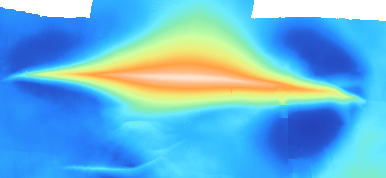
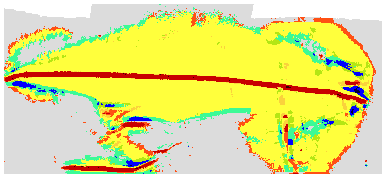

In [9]:
makefigure(['bathy_2015', 'geomorphometry'], 
           label='Output of r.geomorphon, input parameters: search=9 skip=3 flat=2.0 dist=0 step=0 start=0 ')

,

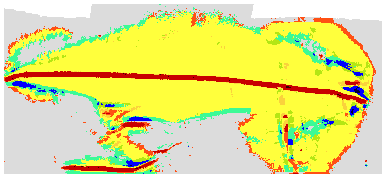
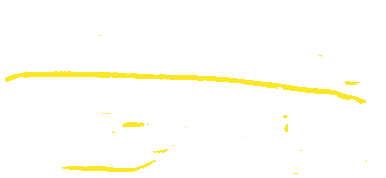

In [10]:
makefigure(['geomorphometry', 'swc'], label='<b>Figure 7:</b> Extraction of sand wave crest (SWC).')

In [11]:
!r.thin input=swc output=swc_thin iterations=400 --o --q

,

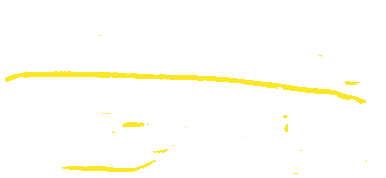
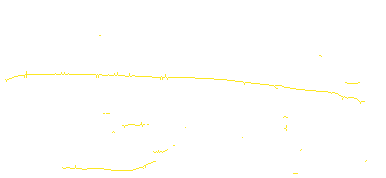

In [12]:
makefigure(['swc', 'swc_thin'], label='<b>Figure 8:</b> SWC thinning.')

In [13]:
!r.clump -d --overwrite input=swc_thin output=swc_thin_clump --q

,

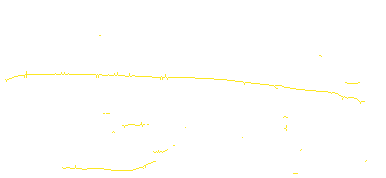
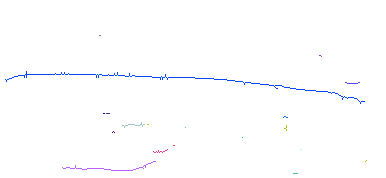

In [14]:
makefigure(['swc_thin', 'swc_thin_clump'], label='<b>Figure 9:</b> SWC clumping.')

In [15]:
!r.area --overwrite input=swc_thin_clump output=swc_thin_long lesser=70 --q

,

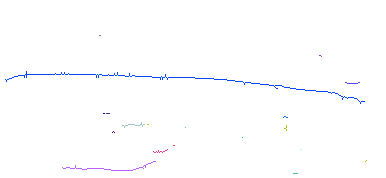
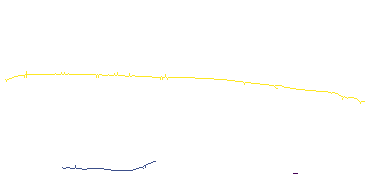

In [16]:
makefigure(['swc_thin_clump','swc_thin_long'], label='<b>Figure 10:</b> SWC filtering by length.')

In [17]:
!r.to.vect input=swc_thin_long output=swc_thin_long_v type=line --o --qq

,

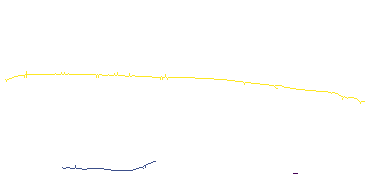
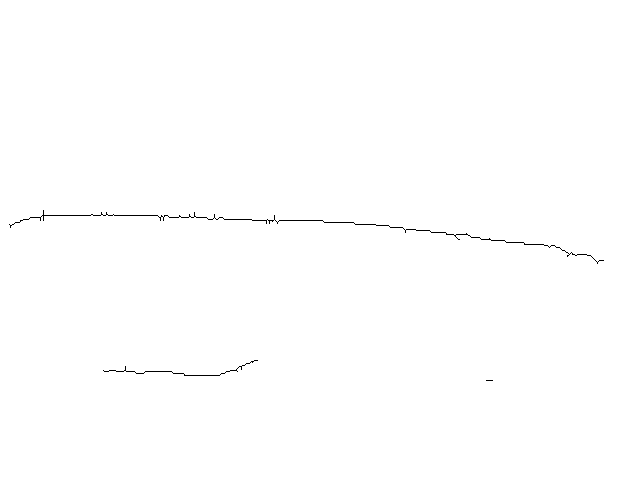

In [18]:
makefigure(['swc_thin_long','swc_thin_long_v'], label='<b>Figure 11:</b> SWC vectorization.')

In [19]:
!v.generalize --overwrite input=swc_thin_long_v output=swc_thin_long_smooth_v method=douglas threshold=2 --qq

,

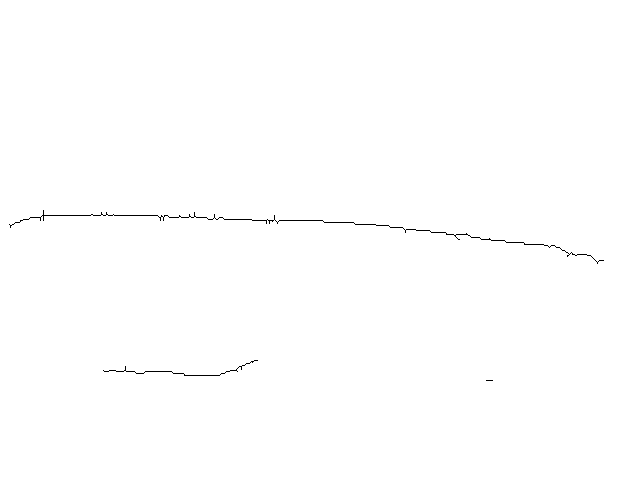
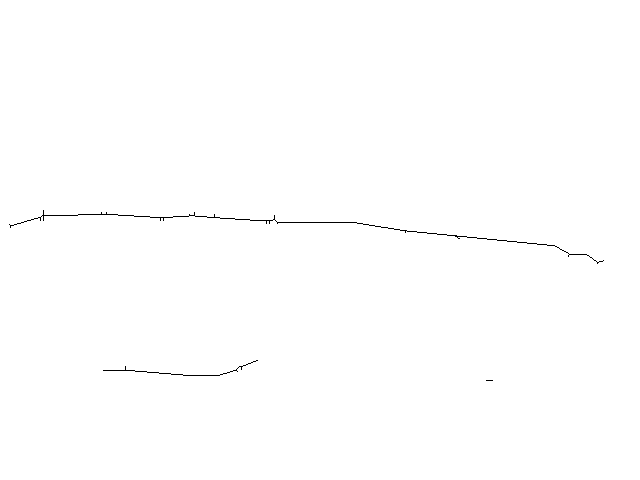

In [20]:
makefigure(['swc_thin_long_v', 'swc_thin_long_smooth_v'], label='<b>Figure 12:</b> SWC topological cleaning.')

In [21]:
!v.clean input=swc_thin_long_smooth_v output=swc_thin_long_smooth_clean_v type=line tool=rmdangle,rmdangle,rmdangle,rmdangle threshold=5,10,20,30 --o --qq


,

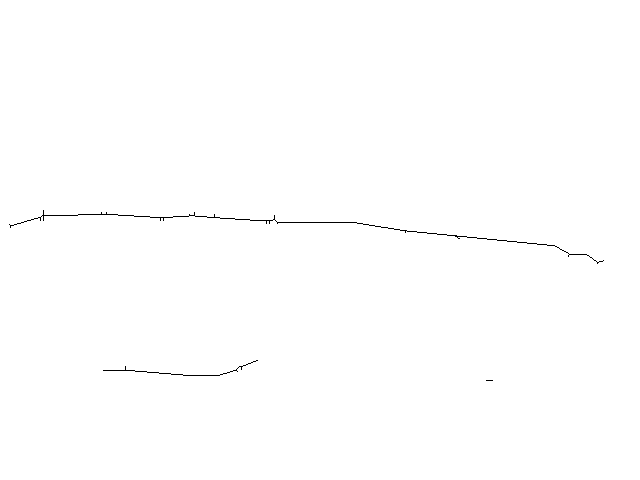
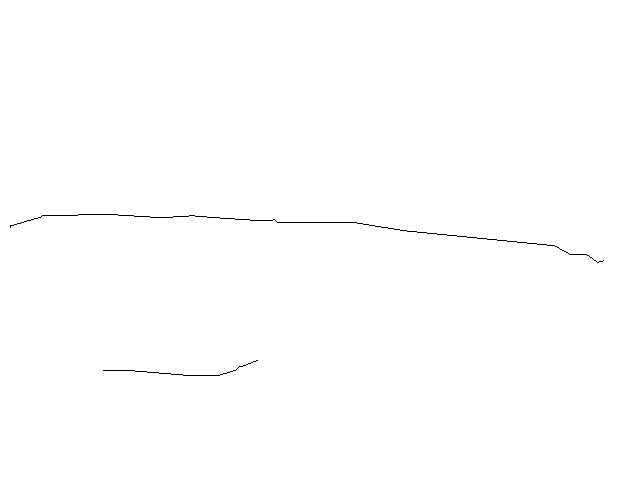

In [22]:
makefigure(['swc_thin_long_smooth_v', 'swc_thin_long_smooth_clean_v'], label='<b>Figure 13:</b> SWC smoothing.')

In [23]:
!g.region n=4546380 s=4546202 w=506185 e=506571 -ap

projection: 1 (UTM)
zone:       19
datum:      wgs84
ellipsoid:  wgs84
north:      4546380
south:      4546202
west:       506185
east:       506571
nsres:      1
ewres:      1
rows:       178
cols:       386
cells:      68708


In [24]:
# large scale features
!r.geomorphon elevation=bathy_2015 forms=geomorphometry_sw search=30 skip=9 flat=3.7 dist=15 step=0 start=0 --o --qq

In [25]:
!r.mapcalc expression="sw=if(geomorphometry_sw==3 | geomorphometry_sw==2 | geomorphometry_sw==6 | geomorphometry_sw==5 , 1, null())" --o --qq


,

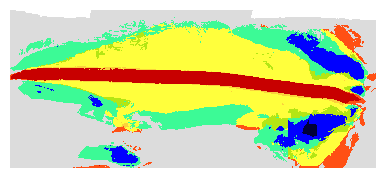
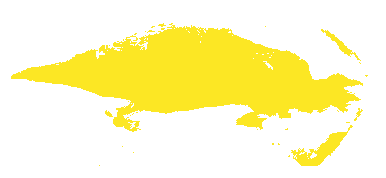

In [26]:
makefigure(['geomorphometry_sw', 'sw'], label='<b>Figure 14:</b> Sand wave (SW) extraction.')

In [27]:
!r.clump -d --overwrite input=sw output=sw_clump --qq

,

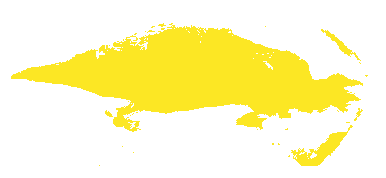
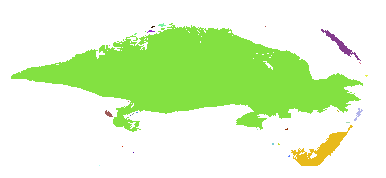

In [28]:
makefigure(['sw', 'sw_clump'], label='<b>Figure 15:</b> SW clumping.')

In [29]:
!r.area input=sw_clump output=sw_clean lesser=1000 --o --qq

,

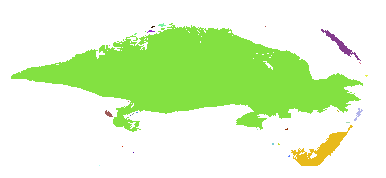
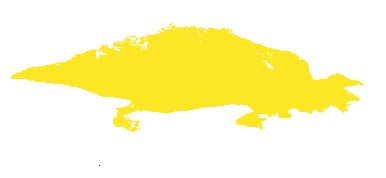

In [30]:
makefigure(['sw_clump', 'sw_clean'], label='<b>Figure 16:</b> SWC filtering by area.')

In [31]:
!r.neighbors input=sw_clean output=sw_clean_fill3 method=maximum --o --qq

,

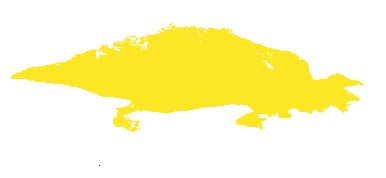
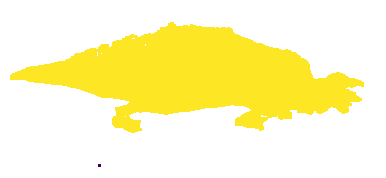

In [32]:
makefigure(['sw_clean','sw_clean_fill3'], label='<b>Figure 17:</b> SW filling.')

In [33]:
!r.to.vect input=sw_clean_fill3 output=sw_clean_fill3_v type=area --o --qq

In [34]:
!g.region n=4546380 s=4546202 w=506185 e=506571 -ap

projection: 1 (UTM)
zone:       19
datum:      wgs84
ellipsoid:  wgs84
north:      4546380
south:      4546202
west:       506185
east:       506571
nsres:      1
ewres:      1
rows:       178
cols:       386
cells:      68708


,

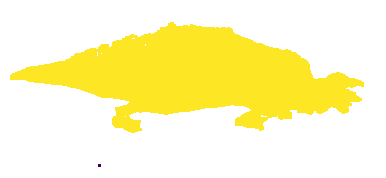
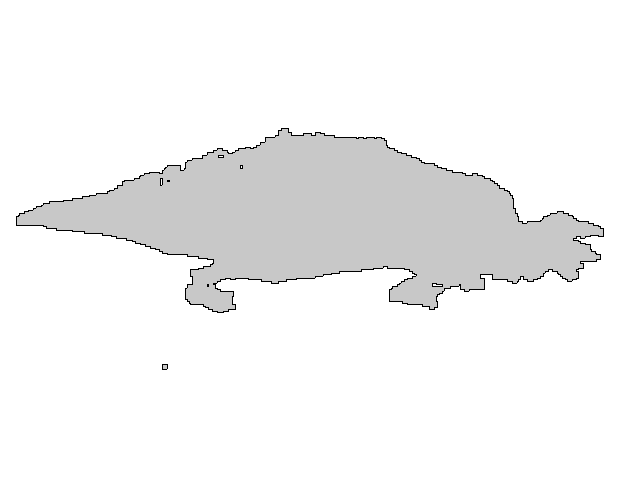

In [35]:
makefigure(['sw_clean_fill3','sw_clean_fill3_v'], label='<b>Figure 18:</b> SW vectorization.')

,

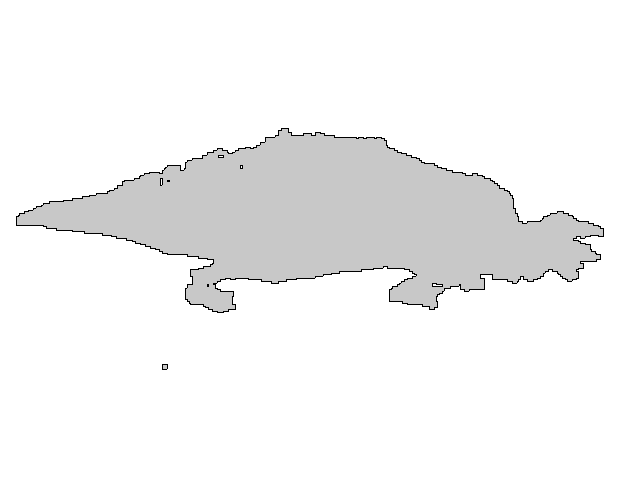
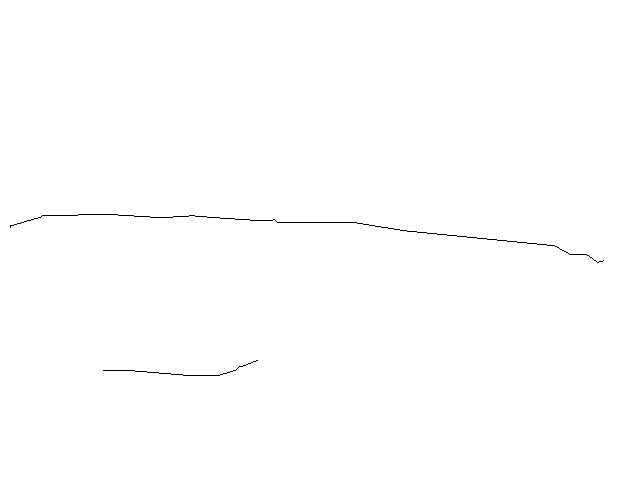

In [36]:
makefigure(['sw_clean_fill3_v','swc_thin_long_smooth_clean_v'], label='<b>Figure 19:</b> SW and SWC overlay.')

In [37]:
!v.overlay ainput=swc_thin_long_smooth_clean_v atype=line binput=sw_clean_fill3_v out=sw_ridges_v operator=and olayer=0,1,0 --o --qq


,

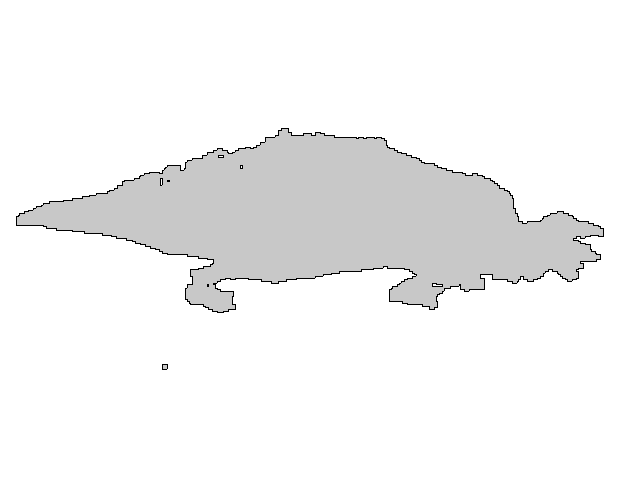
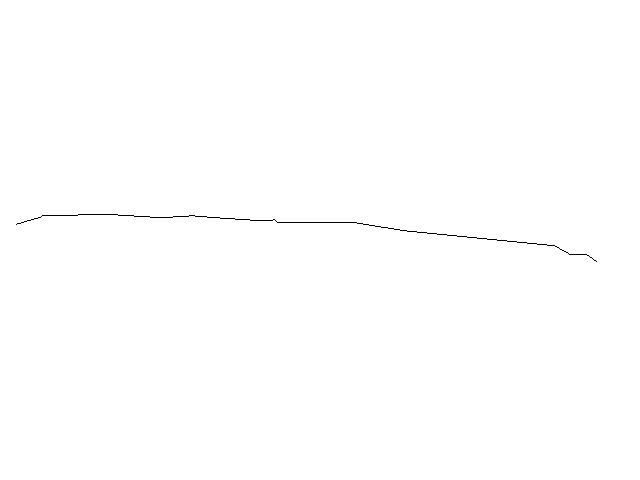

In [38]:
makefigure(['sw_clean_fill3_v','sw_ridges_v'], label='<b>Figure 20:</b> SWC clipping.')

In [39]:
!v.buffer input=sw_ridges_v output=sw_buffer_v distance=1 --o --qq

,

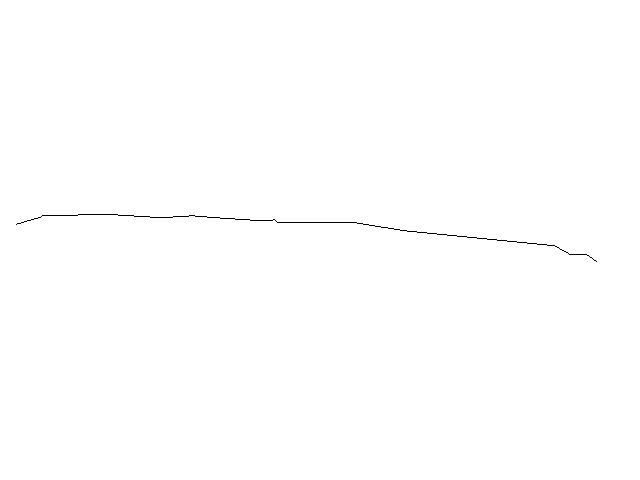
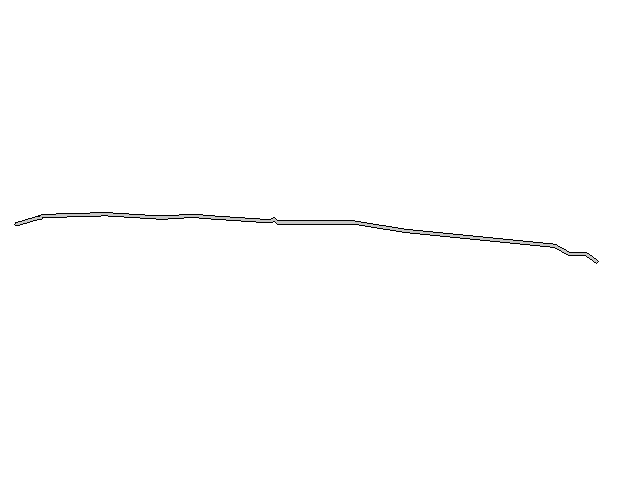

In [40]:
makefigure(['sw_ridges_v','sw_buffer_v'], label='<b>Figure 21:</b> SWC buffering.')

In [41]:
!v.overlay ainput=sw_clean_fill3_v binput=sw_buffer_v operator=not output=sw_splitted_v --o --qq

,

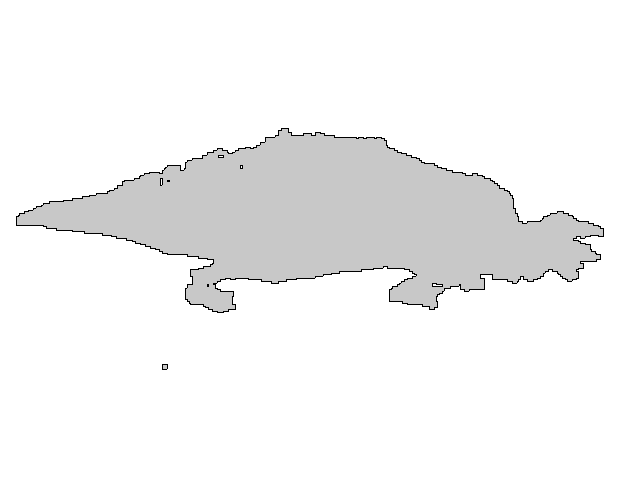
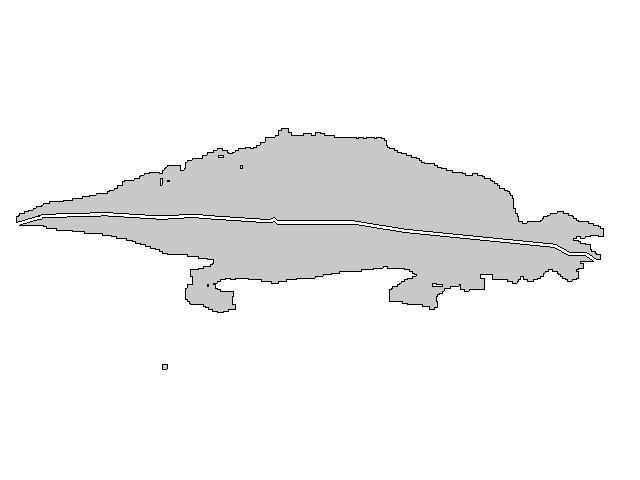

In [42]:
makefigure(['sw_clean_fill3_v','sw_splitted_v'], label='<b>Figure 22:</b> SW splitting.')

In [43]:
#!v.generalize --overwrite input=swc_thin_long_smooth type=line output=swc_thin_long_smooth2 method=snakes threshold=1 alpha=3.0 beta=3.0

In [44]:
!v.split --overwrite input=swc_thin_long_smooth_clean_v output=ridges_smooth_split_v length=70 --qq

In [45]:
!v.transects --overwrite input=ridges_smooth_split_v output=ridges_smooth_transect_v transect_spacing=10 dleft=70 dright=70 --qq


,

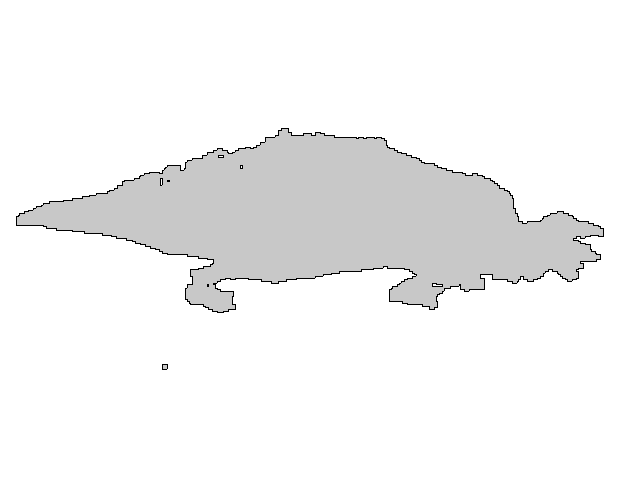
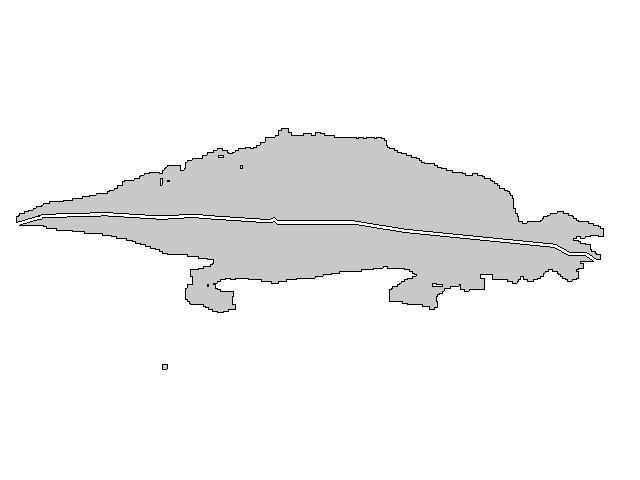

In [46]:
makefigure(['sw_clean_fill3_v','sw_splitted_v'], label="<b>Figure 23:</b> identification od dune's side.")

,

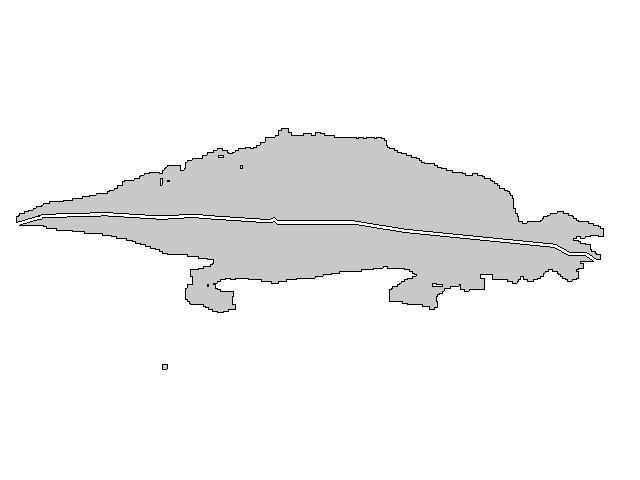
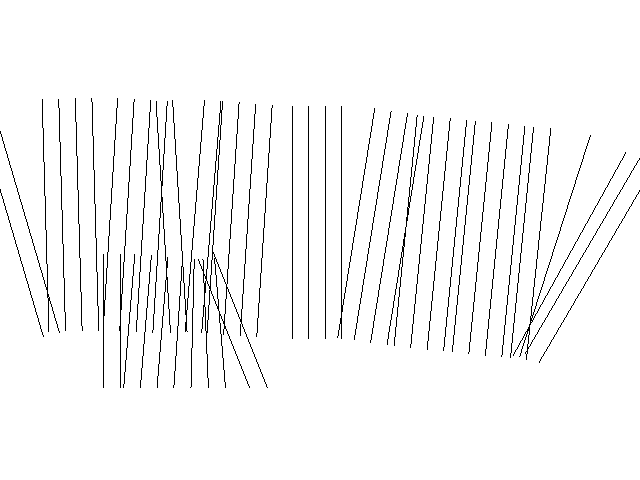

In [47]:
makefigure(['sw_splitted_v','ridges_smooth_transect_v'], label="<center><b>Figure 23:</b> identification of dune's side.</center>")
